# MNIST handwritten digits classification with regularized MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**.

The neural network will be regularized with


1.   Dropout
2.   Batchnormalization





First, the needed imports. 

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
#import seaborn as sns
#sns.set()

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.2.0  Device: cuda


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [2]:
batch_size = 32

train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21862806.51it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 333613.18it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 5857216.76it/s]                           
8192it [00:00, 122375.51it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

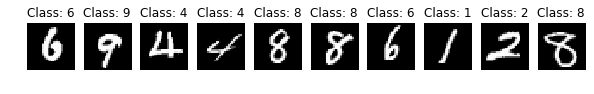

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i].item()))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

#### Question: Complete the missing blocks in the definition of the  convNet architecture 

The neural network should be composed as (FullyConnected 256 -> ReLU -> Fully Connected 256 -> ReLU -> Fully Connected 10 -> softmax)

In [5]:
H1 = 256
H2 = 256 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Question: Complete the missing blocks in the definition of the "DropoutNet" architecture

The neural network should be composed as (FullyConnected 256 -> ReLU -> Dropout (0.2) -> Fully Connected 256 -> ReLU -> Dropout (0.5) -> Fully Connected 10 -> softmax)

In [6]:
class NetDrop(nn.Module):
    def __init__(self):
        super(NetDrop, self).__init__()
        self.fc1 = nn.Linear(28*28, H1)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(H1, H2)
        self.fc2_drop = nn.Dropout(0.5)
        self.fc3 = nn.Linear(H2, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

modelDrop = NetDrop().to(device)
optimizerDrop = torch.optim.SGD(modelDrop.parameters(), lr=0.01, momentum=0.)

print(modelDrop)

NetDrop(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc2_drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### Question: Complete the missing blocks in the definition of the  "Batchnormalization" architecture

The neural network should be composed as (FullyConnected 256 -> ReLU -> Batchnorm -> Fully Connected 256 -> ReLU -> Batchnorm -> Fully Connected 10 -> softmax)

In [7]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        self.fc1 = nn.Linear(28*28, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.fc2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.fc3 = nn.Linear(H2, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        return F.log_softmax(self.fc3(x), dim=1)

modelBatchNorm = NetBatchNorm().to(device)
optimizerBatchNorm = torch.optim.SGD(modelBatchNorm.parameters(), lr=0.01, momentum=0.)

print(modelBatchNorm)

NetBatchNorm(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


## Learning

Let's now define functions to `train()` and `test()` the model. 

In [0]:
def train(model, optimizer, epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [0]:
def validate(model, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `test()`. 

Training without Dropout

In [10]:
%%time
epochs = 3

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312660
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.222943
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.968696
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.542799
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.016104
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.519649
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.357859
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.493173
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.425213
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.386123

Validation set: Average loss: 0.4098, Accuracy: 8840/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.677932
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.283169
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.319959
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.549347
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.508602
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.500589
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.118627
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.171673
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.26

Training with Dropout

In [11]:
%%time

lossvDrop, accvDrop = [], []
for epoch in range(1, epochs + 1):
    train(modelDrop, optimizerDrop, epoch)
    validate(modelDrop, lossvDrop, accvDrop)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296885
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.229132
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.981124
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.624242
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.155881
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.650331
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.784136
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.089157
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.500597
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.613762

Validation set: Average loss: 0.4464, Accuracy: 8778/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.349781
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.380416
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.401751
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.282175
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.615804
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.382230
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.340566
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.630096
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.32

Training with Batchnormalization

In [12]:
%%time

lossvBN, accvBN = [], []
for epoch in range(1, epochs + 1):
    train(modelBatchNorm, optimizerBatchNorm, epoch)
    validate(modelBatchNorm, lossvBN, accvBN)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.389260
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.492876
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.172901
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.180233
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.463625
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.282747
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.359919
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.108271
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.356150
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.061264

Validation set: Average loss: 0.1180, Accuracy: 9659/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.213844
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.083381
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.067084
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.284436
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.215288
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.085632
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.168837
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.138943
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.06

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

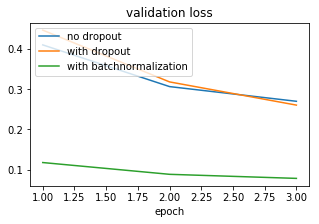

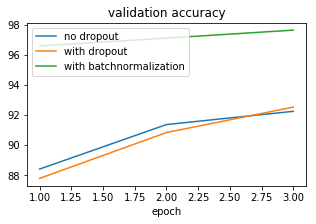

In [13]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='no dropout')
plt.plot(np.arange(1,epochs+1), lossvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), lossvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation loss')
plt.show()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv, label='no dropout')
plt.plot(np.arange(1,epochs+1), accvDrop, label='with dropout')
plt.plot(np.arange(1,epochs+1), accvBN, label='with batchnormalization')
plt.legend(loc='upper left');
plt.xlabel('epoch')
plt.title('validation accuracy');

### Question (model tuning): compare the gain when the first layer has less neurons (50 instead of 256)



### Question (model tuning): increase the number of epochs for the training (10 instead of 3)